In [1]:
# !pip install retina-face

In [2]:

# import cv2
# from retinaface import RetinaFace

# import matplotlib.pyplot as plt
# faces = RetinaFace.extract_faces(img_path = "/content/drive/MyDrive/forgen-man/1.jpeg", align = True)
# for face in faces:
#   plt.imshow(face)
#   plt.show()

In [3]:
# from retinaface import RetinaFace
# resp = RetinaFace.detect_faces("2.jpg")
# cv2.imwrite("../../Desktop/Image.jpg", imCrop)


In [4]:
# !nvidia-smi


In [5]:
import tensorflow as tf
from tensorflow.keras import layers,optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
import os
import datetime

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
dataset_path = '/content/drive/MyDrive/Flowers-20210921T131033Z-001'
width = height = 224
batch_size = 32
data_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    rotation_range = 20,
    zoom_range = 0.1,
    validation_split = 0.2
)

In [8]:
train_data = data_generator.flow_from_directory(
    os.path.join(dataset_path,'Flowers/Train'),
    target_size = (width,height),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    subset= 'training'
)

Found 884 images belonging to 17 classes.


In [9]:
val_data = data_generator.flow_from_directory(
    os.path.join(dataset_path,'Flowers/Train'),
    target_size = (width,height),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    subset= 'validation'
)

Found 204 images belonging to 17 classes.


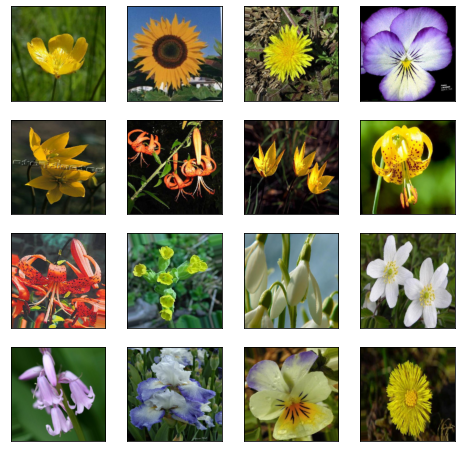

In [10]:
train_images = next(train_data)[0]
plt.figure(figsize=(8,8))

for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i],cmap=plt.cm.binary)



In [11]:
base_model = tf.keras.applications.VGG16(
    input_shape = (width,height,3),
    include_top = False,
    weights = 'imagenet'   

)

58900480/58889256 [==============================] - 1s 0us/step


In [12]:
for layer in base_model.layers:
  layer.trainable = False

In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
model = tf.keras.Sequential([
    base_model, 
    layers.Flatten(),
    layers.Dense(1024,activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(17,activation='softmax')
])

In [15]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 12.4 MB/s 
     |████████████████████████████████| 139 kB 49.8 MB/s 
     |████████████████████████████████| 180 kB 44.7 MB/s 
     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=0062c499736b16e9b7508279272f9d44aa370430b1d2388ef33672c4b1a616ec
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=0ba808f5d50391b7f5da79b07b67ea5c22942a53ab8f1c7fc0a141c308c4ff81
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [16]:
import wandb
from wandb.keras import WandbCallback

In [17]:
wandb.init(project='seventeen-flowers')
config = wandb.config
config.learning_rate = 0.001

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [18]:
model.compile( optimizer = optimizers.Adam(learning_rate=config.learning_rate ),
              loss = losses.categorical_crossentropy,
              metrics =  ['accuracy'])

In [19]:
model.fit(train_data,
          steps_per_epoch = train_data.samples/batch_size,
          validation_data = val_data,
          validation_steps = val_data.samples/batch_size,
          epochs = 10,
          callbacks=[WandbCallback()])

Epoch 1/10
27/27 [==============================] - 532s 18s/step - loss: 3.7147 - accuracy: 0.3224 - val_loss: 1.0931 - val_accuracy: 0.6716
Epoch 2/10
27/27 [==============================] - 22s 803ms/step - loss: 0.8251 - accuracy: 0.7624 - val_loss: 0.5631 - val_accuracy: 0.8382
Epoch 3/10
27/27 [==============================] - 21s 777ms/step - loss: 0.4190 - accuracy: 0.8857 - val_loss: 0.4634 - val_accuracy: 0.8578
Epoch 4/10
27/27 [==============================] - 22s 783ms/step - loss: 0.2635 - accuracy: 0.9287 - val_loss: 0.4702 - val_accuracy: 0.8627
Epoch 5/10
27/27 [==============================] - 21s 776ms/step - loss: 0.1793 - accuracy: 0.9559 - val_loss: 0.5289 - val_accuracy: 0.8627
Epoch 6/10
27/27 [==============================] - 21s 776ms/step - loss: 0.1288 - accuracy: 0.9672 - val_loss: 0.5143 - val_accuracy: 0.8529
Epoch 7/10
27/27 [==============================] - 21s 778ms/step - loss: 0.0878 - accuracy: 0.9819 - val_loss: 0.7109 - val_accuracy: 0.8137


In [23]:
test_data = data_generator.flow_from_directory(
    os.path.join(dataset_path,'Flowers/Test'),
    target_size = (width,height),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    )

Found 272 images belonging to 17 classes.


In [24]:
model.evaluate(test_data)

9/9 [==============================] - 117s 15s/step - loss: 1.1169 - accuracy: 0.6507


[1.1168792247772217, 0.6507353186607361]